<a href="https://colab.research.google.com/github/ZzzandyzzZ/FireNet/blob/main/FireNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de GPU

In [2]:
!nvidia-smi

Tue Jun 28 02:11:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Importación de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/My Drive/UNSA/11 semestre/FireNet")
!ls


'Copia de Our_Complete_Dataset_Video_and_extra_NoFire_Frames.zip'
'Copia de Test_Dataset1__Our_Own_Dataset.zip'
'Copia de Training Dataset.zip'
 FireNet.ipynb
'Training Dataset'


In [6]:
#!unzip 'Copia de Training Dataset.zip'

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [8]:
DATADIR = 'Training Dataset'
CATEGORIES = ['Fire', 'NoFire']

In [9]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:  
        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O
        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return training_data

In [10]:
training_data = create_training_data()


100%|██████████| 1301/1301 [00:26<00:00, 48.44it/s]


In [11]:
import random

print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

2423
1
0
1
0
1
1
0
1
1
0


In [12]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X.shape[1:]

(64, 64, 3)

In [13]:
# # set up image augmentation
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
#     #zoom_range=0.3
#     )
# datagen.fit(X)

In [14]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
print(tf.__version__)

1.15.2


In [16]:
history = model.fit(X, Y, batch_size=32, epochs=100,validation_split=0.3)
# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                     verbose=1)


Train on 1696 samples, validate on 727 samples
Epoch 1/100
1696/1696 [==============================] - 5s 3ms/sample - loss: 0.5853 - acc: 0.6887 - val_loss: 0.5089 - val_acc: 0.7510
Epoch 2/100
1696/1696 [==============================] - 0s 236us/sample - loss: 0.5437 - acc: 0.7388 - val_loss: 0.5437 - val_acc: 0.7483
Epoch 3/100
1696/1696 [==============================] - 0s 232us/sample - loss: 0.4831 - acc: 0.7824 - val_loss: 0.4354 - val_acc: 0.8171
Epoch 4/100
1696/1696 [==============================] - 0s 226us/sample - loss: 0.4437 - acc: 0.8007 - val_loss: 0.4344 - val_acc: 0.7937
Epoch 5/100
1696/1696 [==============================] - 0s 230us/sample - loss: 0.4219 - acc: 0.8166 - val_loss: 0.3950 - val_acc: 0.8102
Epoch 6/100
1696/1696 [==============================] - 0s 222us/sample - loss: 0.3963 - acc: 0.8249 - val_loss: 0.4375 - val_acc: 0.7854
Epoch 7/100
1696/1696 [==============================] - 0s 216us/sample - loss: 0.3816 - acc: 0.8314 - val_loss: 0.3866 

In [19]:
model.save('TrainedModels/Fire-64x64-color-v7.1-soft.h5')

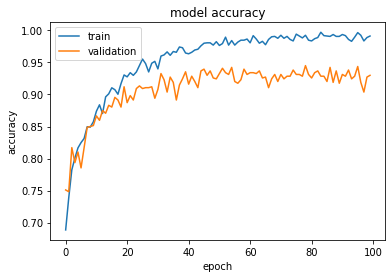

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

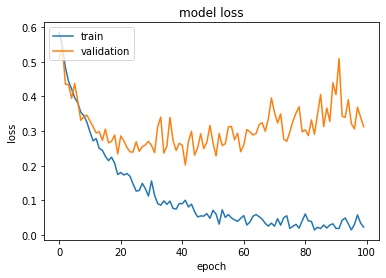

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

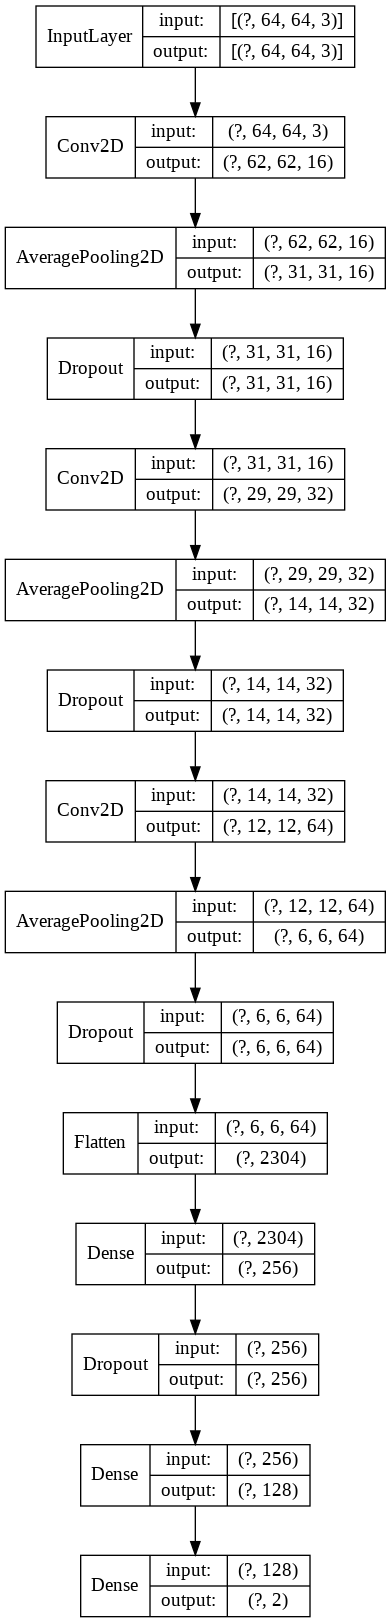

In [24]:
plot_model(model, to_file='model_small.png', show_layer_names=False, show_shapes=True)